## How many of trips were done by musclular fit customers?

In [28]:
import requests
import time
import pandas as pd
from tqdm import tqdm  # Import tqdm for progress bars
import matplotlib.pyplot as plt
from math import ceil



### Read 2024 data file and calculate travel time

In [2]:

def calculate_total_trip_time():
    # Define file paths
    input_file = "raw_data/BixiMontrealRentals2024/OD_2024.csv"
    output_file = "question3_data/2024TripTimeTable.csv"
    
    # Read the CSV file
    df = pd.read_csv(input_file)
    
    # Calculate total trip time in seconds (ENDTIMEMS - STARTTIMEMS) / 1000
    df['TOTALTRIPTIME'] = (df['ENDTIMEMS'] - df['STARTTIMEMS']) / 1000  # Convert milliseconds to seconds
    
    # Select relevant columns for output
    output_df = df[['STARTSTATIONLATITUDE', 'STARTSTATIONLONGITUDE', 'ENDSTATIONLATITUDE', 'ENDSTATIONLONGITUDE', 'TOTALTRIPTIME']]
    
    # Write the result to a new CSV file
    output_df.to_csv(output_file, index=False)
    
    print(f"File {output_file} has been created successfully.")

# Run the function
calculate_total_trip_time()


File question3_data/2024TripTimeTable.csv has been created successfully.


In [14]:

def get_api_key(file_path):
    """Reads the API key from the specified file."""
    with open(file_path, 'r') as file:
        return file.readline().strip()

def get_bicycle_time(api_key, start_lat, start_lng, end_lat, end_lng):
    # Google Maps Distance Matrix API URL
    url = "https://maps.googleapis.com/maps/api/distancematrix/json"
    
    # Define parameters for the API request
    params = {
        'origins': f"{start_lat},{start_lng}",
        'destinations': f"{end_lat},{end_lng}",
        'mode': 'bicycling',  # Set mode to bicycling
        'key': api_key,
    }
    
    # Send the request to the API
    response = requests.get(url, params=params)
    data = response.json()
    
    # Check for a valid response
    if data['status'] == 'OK':
        try:
            # Extract the travel time from the response in seconds
            travel_time_seconds = data['rows'][0]['elements'][0]['duration']['value']
            return travel_time_seconds
        except (IndexError, KeyError):
            return None  # Return None if there is an issue
    else:
        return None  # Return None for any other API issue


In [13]:
def calculate_estimated_trip_time():
    # Load the API key from the text file
    api_key = get_api_key("apikey.txt")
    
    # Load the data from 2024TripTimeTable.csv
    input_file = "question3_data/2024TripTimeTable.csv"
    df = pd.read_csv(input_file)
    
    # Initialize an empty list to store estimated trip times
    estimated_times = []
    
    # Use tqdm for a progress bar
    print("Starting to calculate estimated trip times...")
    for index, row in tqdm(df.iterrows(), total=len(df)):
        start_lat = row['STARTSTATIONLATITUDE']
        start_lng = row['STARTSTATIONLONGITUDE']
        end_lat = row['ENDSTATIONLATITUDE']
        end_lng = row['ENDSTATIONLONGITUDE']
        
        # Get estimated bicycle time
        estimated_time = get_bicycle_time(api_key, start_lat, start_lng, end_lat, end_lng)
        
        # If estimated time is None, put NaN, else append the time
        estimated_times.append(estimated_time if estimated_time is not None else pd.NA)
        
        # To avoid hitting API rate limits, you can add a small delay
        time.sleep(1)  # Sleep for 1 second between requests
    
    print(f"All rows processed. Saving results to {input_file}...")
    
    # Add the estimated trip times to the dataframe
    df['ESTIMATEDTRIPTIME'] = estimated_times
    
    # Save the updated dataframe back to the same CSV file
    df.to_csv(input_file, index=False)
    
    print(f"File {input_file} has been updated with ESTIMATEDTRIPTIME.")

# Run the function
calculate_estimated_trip_time()

Starting to calculate estimated trip times...


  0%|          | 0/6688069 [00:00<?, ?it/s]

travel time: 334


  0%|          | 1/6688069 [00:01<2310:35:35,  1.24s/it]

travel time: 447


  0%|          | 2/6688069 [00:02<2643:05:53,  1.42s/it]

travel time: 419


KeyboardInterrupt: 

In [33]:


def calculate_test_estimated_trip_time():
    """Calculates estimated trip time for a sample of 100 records and saves to test file."""
    
    # Load the API key from the text file
    api_key = get_api_key("apikey.txt")
    
    # Load the data from 2024TripTimeTable.csv
    input_file = "question3_data/2024TripTimeTable.csv"
    df = pd.read_csv(input_file)
    
    # Sample 100 records from the dataframe
    df_sample = df.sample(n=500, random_state=42) #0.01% of records sampled
    print(len(df_sample))
    
    # Initialize an empty list to store estimated trip times
    estimated_times = []
    
    # Use tqdm for a progress bar to track the process
    print("Calculating estimated trip times for the sample of 100 records...")
    for index, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
        start_lat = row['STARTSTATIONLATITUDE']
        start_lng = row['STARTSTATIONLONGITUDE']
        end_lat = row['ENDSTATIONLATITUDE']
        end_lng = row['ENDSTATIONLONGITUDE']
        
        # Get estimated bicycle time
        estimated_time = get_bicycle_time(api_key, start_lat, start_lng, end_lat, end_lng)
        
        # If estimated time is None, put NaN, else append the time
        estimated_times.append(estimated_time if estimated_time is not None else pd.NA)
        
        # To avoid hitting API rate limits, you can add a small delay
        time.sleep(1)  # Sleep for 1 second between requests
    
    print("All records processed. Saving results to test_estimated_time.csv...")
    
    # Add the estimated trip times to the sampled dataframe
    df_sample['ESTIMATEDTRIPTIME'] = estimated_times
    
    # Save the updated dataframe to a new CSV file
    output_file = "question3_data/test_estimated_time.csv"
    df_sample.to_csv(output_file, index=False)
    
    print(f"File {output_file} has been created with estimated trip times.")

# Run the test function
calculate_test_estimated_trip_time()

500
Calculating estimated trip times for the sample of 100 records...


 48%|████▊     | 242/500 [20:03<21:22,  4.97s/it]


ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

### Calulate difference absolute value

In [23]:
def calculate_trip_time_differences(file_name):
    """Calculates the absolute difference between TOTALTRIPTIME and ESTIMATEDTRIPTIME and saves the result."""
    
    # Load the data from the specified file
    df = pd.read_csv(file_name)
    
    # Check if the necessary columns exist in the dataset
    if 'TOTALTRIPTIME' not in df.columns or 'ESTIMATEDTRIPTIME' not in df.columns:
        print("Error: Required columns TOTALTRIPTIME and ESTIMATEDTRIPTIME are missing.")
        return
    
    # Calculate the absolute difference between TOTALTRIPTIME and ESTIMATEDTRIPTIME
    df['difference_absolute'] = (df['TOTALTRIPTIME'] - df['ESTIMATEDTRIPTIME'])
    
    # Save the updated dataframe back to the same file
    df.to_csv(file_name, index=False)
    
    print(f"File {file_name} has been updated with the 'difference_absolute' column.")

# Example usage
calculate_trip_time_differences("question3_data/test_estimated_time.csv")

File question3_data/test_estimated_time.csv has been updated with the 'difference_absolute' column.


### plot the data

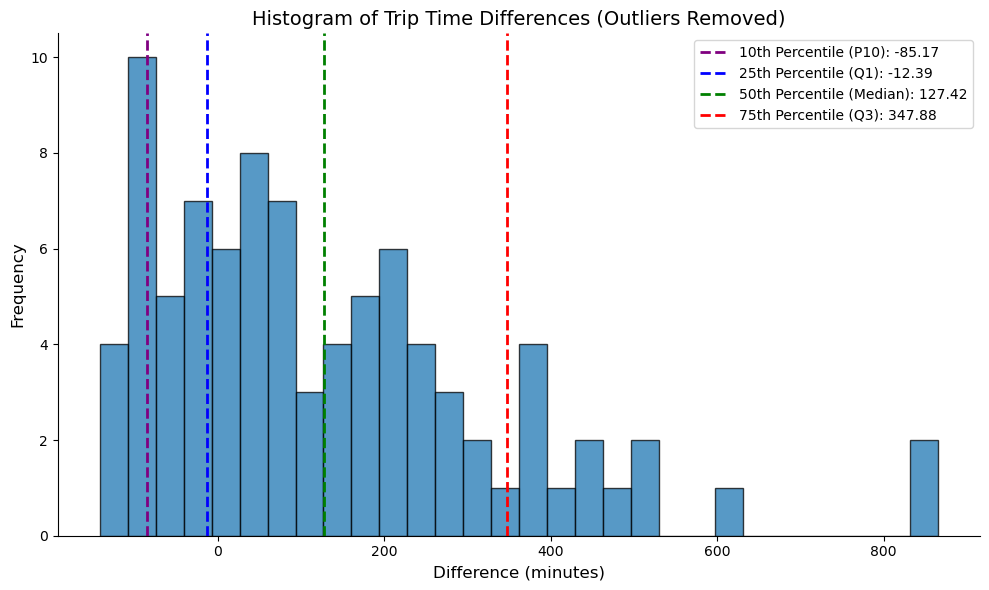

In [25]:

def plot_trip_estimated_real(file_name):
    """Plots a histogram of the absolute differences between estimated and real trip times, with outliers removed, 
    and shows the 10th, 25th, 50th, and 75th percentiles on the plot."""
    
    # Load the data from the specified file
    df = pd.read_csv(file_name)
    
    # Check if the 'difference_absolute' column exists in the dataset
    if 'difference_absolute' not in df.columns:
        print("Error: Required column 'difference_absolute' is missing.")
        return
    
    # Remove outliers using the Interquartile Range (IQR) method
    Q1 = df['difference_absolute'].quantile(0.25)
    Q3 = df['difference_absolute'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df['difference_absolute'] >= lower_bound) & (df['difference_absolute'] <= upper_bound)]
    
    # Calculate additional percentiles
    P10 = df['difference_absolute'].quantile(0.10)
    P25 = df['difference_absolute'].quantile(0.25)  # This is Q1
    P50 = df['difference_absolute'].quantile(0.50)  # This is the median
    P75 = df['difference_absolute'].quantile(0.75)  # This is Q3

    # Create a histogram of the filtered data
    plt.figure(figsize=(10, 6))
    plt.hist(df_filtered['difference_absolute'].dropna(), bins=30, alpha=0.75, edgecolor='black')

    # Add vertical lines for each percentile
    plt.axvline(P10, color='purple', linestyle='dashed', linewidth=2, label=f'10th Percentile (P10): {P10:.2f}')
    plt.axvline(P25, color='blue', linestyle='dashed', linewidth=2, label=f'25th Percentile (Q1): {P25:.2f}')
    plt.axvline(P50, color='green', linestyle='dashed', linewidth=2, label=f'50th Percentile (Median): {P50:.2f}')
    plt.axvline(P75, color='red', linestyle='dashed', linewidth=2, label=f'75th Percentile (Q3): {P75:.2f}')
    
    # Add labels and title
    plt.xlabel('Difference (minutes)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Histogram of Trip Time Differences (Outliers Removed)', fontsize=14)
    
    # Apply your plot settings
    plt.xticks(rotation=0)  # Horizontal x-axis labels
    plt.gca().spines['top'].set_visible(False)  # Remove top border
    plt.gca().spines['right'].set_visible(False)  # Remove right border
    
    # Add legend to explain the percentile lines
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage
plot_trip_estimated_real("question3_data/test_estimated_time.csv")